# Importing the Libraries

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import optuna


sns.set_palette('crest')

# Importing the Dataset

In [32]:
df = pd.read_csv('../Data/results_v6.csv')
df.sample(5)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
12136,Artificer,28,17,3,Ranger,32,16,3,Rogue,18,...,12,3,6,Duergar Soulblade,1.0,14,27,humanoid,0.000000,3
1239,Sorcerer,12,13,2,Sorcerer,15,11,2,Druid,15,...,15,2,1,Banderhobb,5.0,15,84,monstrosity,0.000000,2
72850,Cleric,5,13,2,Monk,10,10,2,Bard,7,...,11,2,1,Giant Vulture,1.0,10,22,beast,0.844444,1
99247,Rogue,33,13,3,Barbarian,42,14,3,Warlock,34,...,14,3,10,Swarm of Beetles,0.5,12,22,beast,0.000000,4
19025,Rogue,31,16,3,Sorcerer,12,13,3,Paladin,33,...,16,3,3,Lamia,4.0,13,97,monstrosity,0.305331,4


In [33]:
df_test = pd.read_csv('../Data/test_sample.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         4488 non-null   object 
 1   p1_hp            4488 non-null   int64  
 2   p1_ac            4488 non-null   int64  
 3   p1_avg_save      4488 non-null   int64  
 4   p2_class         4488 non-null   object 
 5   p2_hp            4488 non-null   int64  
 6   p2_ac            4488 non-null   int64  
 7   p2_avg_save      4488 non-null   int64  
 8   p3_class         4488 non-null   object 
 9   p3_hp            4488 non-null   int64  
 10  p3_ac            4488 non-null   int64  
 11  p3_avg_save      4488 non-null   int64  
 12  p4_class         4488 non-null   object 
 13  p4_hp            4488 non-null   int64  
 14  p4_ac            4488 non-null   int64  
 15  p4_avg_save      4488 non-null   int64  
 16  num_of_monsters  4488 non-null   int64  
 17  monster_name  

In [34]:
df_test_result = df_test['dificulty']==0
df_test_result.head()

0    False
1    False
2    False
3    False
4     True
Name: dificulty, dtype: bool

# Cleaning the Data

## Dropping miswrote data

In [35]:
df = df[df['p1_class'] != '22']
df = df[df['dificulty'] >= 0]
df = df[df['monster_cr'] != -1]
df = df[df['players_level'] <= 5]
print(df.shape)
df.head()

(102817, 24)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,14,3,1,Efreeti,11.00,17,200,elemental,0.869491,5
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,15,3,10,Giant Bat,0.25,13,22,beast,0.067640,3
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,2,1,Galeb Duhr,6.00,16,85,elemental,1.000000,2
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,13,3,1,Blue Slaad,7.00,15,123,aberration,0.285597,3
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,13,3,4,Lizardfolk Shaman,2.00,13,27,humanoid,0.445773,4


## Dropping unuseful columns

In [36]:
df['TPK'] = df['dificulty'] == 0
df.drop(columns=['dificulty','monster_name'], axis=1, inplace=True)
print(df.shape)
df.head()

(102817, 23)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,monster_type,players_level,TPK
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,43,14,3,1,11.00,17,200,elemental,5,False
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,25,15,3,10,0.25,13,22,beast,3,False
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,14,2,1,6.00,16,85,elemental,2,False
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,27,13,3,1,7.00,15,123,aberration,3,False
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,25,13,3,4,2.00,13,27,humanoid,4,False


In [37]:
df_test.drop(columns=['monster_name','dificulty'], inplace=True)
print(df_test.shape)
df_test.head()

(4488, 22)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_class,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,monster_type,players_level
0,Fighter,10,18,2,Artificer,9,17,2,Cleric,6,...,Cleric,8,18,2,1,1.00,13,28,beast,1
1,Paladin,40,18,3,Rogue,25,16,3,Fighter,37,...,Ranger,57,17,3,1,5.00,15,75,monstrosity,5
2,Warlock,15,13,2,Ranger,17,16,2,Fighter,17,...,Cleric,12,14,2,2,2.00,13,30,beast,2
3,Monk,16,13,3,Monk,18,11,3,Paladin,26,...,Artificer,30,12,3,1,5.00,13,95,beast,3
4,Wizzard,4,11,2,Paladin,11,15,2,Sorcerer,6,...,Bard,6,16,2,10,0.25,15,11,construct,1


# Exploring the Data

<Axes: xlabel='TPK', ylabel='count'>

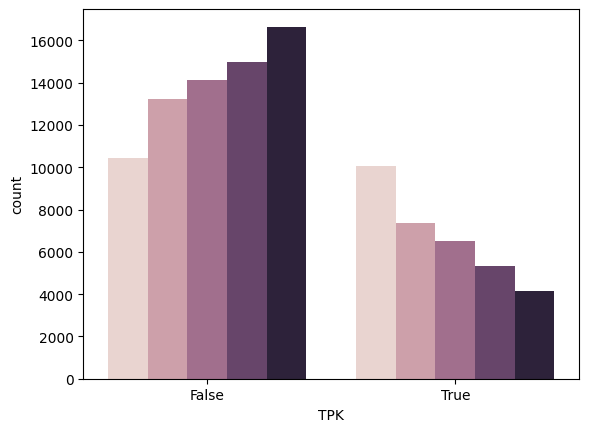

In [38]:
sns.countplot(x='TPK', data=df, hue='players_level', legend=False)

<Axes: xlabel='TPK', ylabel='count'>

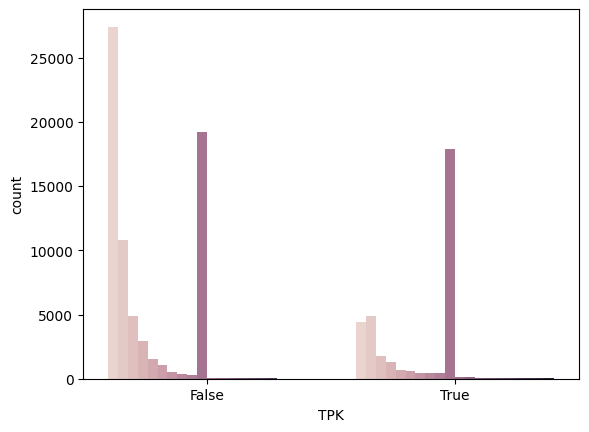

In [45]:
sns.countplot(x='TPK', data=df, hue='num_of_monsters', legend=False)

In [39]:
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['TPK']).sort_values(ascending = False)

TPK                1.000000
num_of_monsters    0.302892
players_level      0.204874
p3_hp              0.203828
p1_hp              0.202123
p2_hp              0.201363
p4_hp              0.200979
p2_avg_save        0.173201
p3_avg_save        0.173201
p4_avg_save        0.173201
p1_avg_save        0.173201
p3_ac              0.041813
p4_ac              0.040716
p1_ac              0.040125
p2_ac              0.036435
monster_cr         0.036085
monster_hp         0.009135
monster_ac         0.003594
Name: TPK, dtype: float64

In [40]:
corr_matrix

,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,players_level,TPK
p1_hp,1.000000,0.097779,0.760145,0.771475,-0.000335,0.760145,0.771640,-0.002646,0.760145,0.771471,0.001654,0.760145,0.011625,0.307554,0.135904,0.277164,0.877996,-0.202123
p1_ac,0.097779,1.000000,0.003035,0.003665,0.003515,0.003035,0.006203,0.002559,0.003035,0.005389,-0.002774,0.003035,-0.003024,0.003276,0.002211,0.001906,0.005144,-0.040125
p1_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.865503,-0.173201
p2_hp,0.771475,0.003665,0.760556,1.000000,0.096176,0.760556,0.770257,-0.002652,0.760556,0.772318,0.002066,0.760556,0.010628,0.308320,0.135374,0.276738,0.878134,-0.201363
p2_ac,-0.000335,0.003515,0.002004,0.096176,1.000000,0.002004,-0.001092,0.000018,0.002004,-0.000010,-0.003318,0.002004,0.004797,-0.004691,-0.007957,-0.002871,-0.000855,-0.036435
p2_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.865503,-0.173201
p3_hp,0.771640,0.006203,0.760603,0.770257,-0.001092,0.760603,1.000000,0.091890,0.760603,0.771941,0.002221,0.760603,0.010298,0.308398,0.135855,0.276856,0.877997,-0.203828
p3_ac,-0.002646,0.002559,0.002767,-0.002652,0.000018,0.002767,0.091890,1.000000,0.002767,-0.001706,-0.003256,0.002767,-0.004786,0.002592,0.000725,0.001429,-0.002621,-0.041813
p3_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.865503,-0.173201
p4_hp,0.771471,0.005389,0.760499,0.772318,-0.000010,0.760499,0.771941,-0.001706,0.760499,1.000000,0.095816,0.760499,0.009680,0.311439,0.137778,0.280842,0.878698,-0.200979


# Sampling the data

In [47]:
X = df.drop(columns=['TPK'], axis=1)
Y = df['TPK']

## One hot encoding

In [48]:
encoder_class = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

features_df = encoder_class.fit_transform(X[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']]) # type: ignore
X_encoded = pd.concat([X, features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type'])
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102817 entries, 0 to 103085
Data columns (total 83 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p1_hp                     102817 non-null  int64  
 1   p1_ac                     102817 non-null  int64  
 2   p1_avg_save               102817 non-null  int64  
 3   p2_hp                     102817 non-null  int64  
 4   p2_ac                     102817 non-null  int64  
 5   p2_avg_save               102817 non-null  int64  
 6   p3_hp                     102817 non-null  int64  
 7   p3_ac                     102817 non-null  int64  
 8   p3_avg_save               102817 non-null  int64  
 9   p4_hp                     102817 non-null  int64  
 10  p4_ac                     102817 non-null  int64  
 11  p4_avg_save               102817 non-null  int64  
 12  num_of_monsters           102817 non-null  int64  
 13  monster_cr                102817 non-null  float6

In [49]:
test_features_df = encoder_class.transform(df_test[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']]) # type: ignore
df_test_encoded = pd.concat([df_test, test_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type'])
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 83 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p1_hp                     4488 non-null   int64  
 1   p1_ac                     4488 non-null   int64  
 2   p1_avg_save               4488 non-null   int64  
 3   p2_hp                     4488 non-null   int64  
 4   p2_ac                     4488 non-null   int64  
 5   p2_avg_save               4488 non-null   int64  
 6   p3_hp                     4488 non-null   int64  
 7   p3_ac                     4488 non-null   int64  
 8   p3_avg_save               4488 non-null   int64  
 9   p4_hp                     4488 non-null   int64  
 10  p4_ac                     4488 non-null   int64  
 11  p4_avg_save               4488 non-null   int64  
 12  num_of_monsters           4488 non-null   int64  
 13  monster_cr                4488 non-null   float64
 14  monster_

In [50]:
print(len(Y))
print(len(X_encoded))

102817
102817


In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=7)

# Building the Model

## Making a rough model, without any hyperparameter tuning

[0]	validation_0-logloss:0.52058	validation_1-logloss:0.52155
[99]	validation_0-logloss:0.17656	validation_1-logloss:0.21990


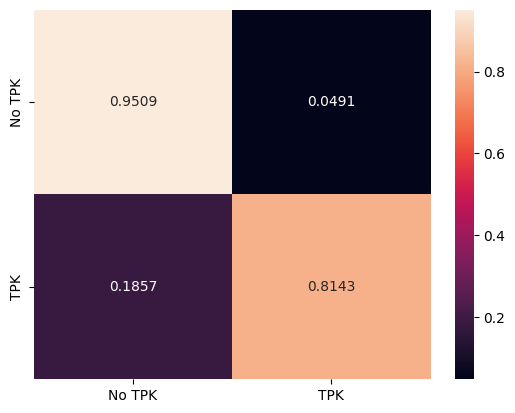

In [59]:
clfXGB = XGBClassifier()
clfXGB.fit( X_train,
            Y_train,
            verbose=100,
            eval_set=[(X_train, Y_train),(X_test, Y_test)]
            )

ax = sns.heatmap(confusion_matrix(Y_test, clfXGB.predict(X_test), normalize='true'), annot=True, fmt='.4f', xticklabels=['No TPK', 'TPK'], yticklabels=['No TPK', 'TPK'])


In [76]:
test = classification_report(Y_test, clfXGB.predict(X_test))
test.split('\n')

['              precision    recall  f1-score   support',
 '',
 '       False       0.91      0.95      0.93     13877',
 '        True       0.89      0.81      0.85      6687',
 '',
 '    accuracy                           0.91     20564',
 '   macro avg       0.90      0.88      0.89     20564',
 'weighted avg       0.91      0.91      0.91     20564',
 '']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

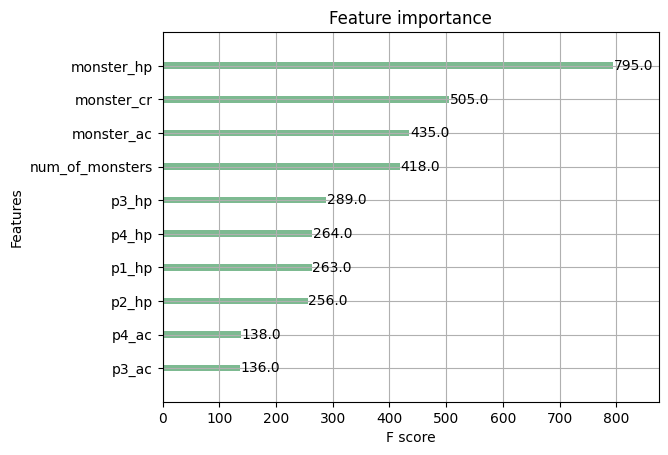

In [71]:
plot_importance(clfXGB, max_num_features=10)

## Tuning the hyperparameters using Optuna

In [72]:
skf = StratifiedKFold(10, shuffle=True, random_state=7)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=7, n_jobs=-1)

    return cross_val_score(cls, X_train, Y_train,
                           cv=skf, scoring='accuracy').mean()

In [73]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', study_name='classification')
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)
studyXGB.best_params

[I 2023-12-09 17:49:15,287] A new study created in memory with name: classification
[I 2023-12-09 17:49:51,623] Trial 6 finished with value: 0.8416106215225355 and parameters: {'n_estimators': 77, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.3, 'min_child_weight': 3, 'colsample_bytree': 0.7}. Best is trial 6 with value: 0.8416106215225355.
[I 2023-12-09 17:49:57,275] Trial 8 finished with value: 0.8408689506250845 and parameters: {'n_estimators': 52, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'min_child_weight': 7, 'colsample_bytree': 0.6000000000000001}. Best is trial 6 with value: 0.8416106215225355.
[I 2023-12-09 17:49:57,759] Trial 4 finished with value: 0.8638104372155306 and parameters: {'n_estimators': 64, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.3, 'min_child_weight': 2, 'colsample_bytree': 0.3}. Best is trial 4 with value: 0.8638104372155306.
[I 2023-12-09 17:50:01,470] Trial 7 finished with value: 0.8766853101996265 and parameters: {'n_es

{'n_estimators': 193,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

In [74]:
# params = studyXGB.best_params
params = {
    'n_estimators': 193,
    'max_depth': 7,
    'learning_rate': 0.2,
    'gamma': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.5
}

0.9739889162081019
              precision    recall  f1-score   support

       False       0.92      0.96      0.94     13877
        True       0.90      0.83      0.86      6687

    accuracy                           0.92     20564
   macro avg       0.91      0.89      0.90     20564
weighted avg       0.91      0.92      0.91     20564



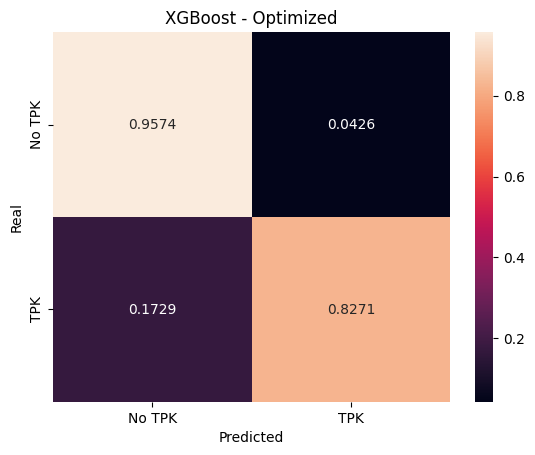

In [75]:
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, Y_train)

# Matriz de confusão do modelo XGBoost otimizado
ax = sns.heatmap(confusion_matrix(Y_test, xgb_optuna.predict(X_test), normalize='true'), annot=True, fmt='.4f', xticklabels=['No TPK', 'TPK'], yticklabels=['No TPK', 'TPK'])
ax.set_title('XGBoost - Optimized')
ax.set_xlabel('Predicted')
ax.set_ylabel('Real');
print(roc_auc_score(Y_test, xgb_optuna.predict_proba(X_test)[:,1]))
print(classification_report(Y_test, xgb_optuna.predict(X_test)))

## Balancing the model results between True positives and True negatives

In [77]:
pesos = np.round(np.arange(0.5, 3, 0.01), 5)

params['random_state'] = 7

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, Y_train)
    Y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.01:

        print(i)
        print(classification_report(Y_test, Y_pred))

        print()

2.11
              precision    recall  f1-score   support

       False       0.95      0.92      0.93     13877
        True       0.84      0.91      0.87      6687

    accuracy                           0.91     20564
   macro avg       0.90      0.91      0.90     20564
weighted avg       0.92      0.91      0.91     20564


2.12
              precision    recall  f1-score   support

       False       0.95      0.92      0.93     13877
        True       0.84      0.91      0.87      6687

    accuracy                           0.91     20564
   macro avg       0.89      0.91      0.90     20564
weighted avg       0.92      0.91      0.91     20564


2.13
              precision    recall  f1-score   support

       False       0.95      0.91      0.93     13877
        True       0.83      0.90      0.86      6687

    accuracy                           0.91     20564
   macro avg       0.89      0.91      0.90     20564
weighted avg       0.91      0.91      0.91     20564


2

0.9737750049708771
              precision    recall  f1-score   support

       False       0.96      0.90      0.93     13877
        True       0.82      0.91      0.86      6687

    accuracy                           0.91     20564
   macro avg       0.89      0.91      0.90     20564
weighted avg       0.91      0.91      0.91     20564



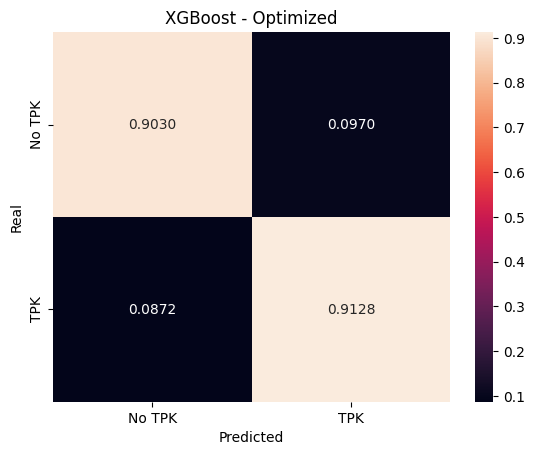

In [78]:
params['scale_pos_weight'] = 2.45

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, Y_train)

# Matriz de confusão do modelo XGBoost otimizado
ax = sns.heatmap(confusion_matrix(Y_test, xgb_optuna.predict(X_test), normalize='true'), annot=True, fmt='.4f', xticklabels=['No TPK', 'TPK'], yticklabels=['No TPK', 'TPK'])
ax.set_title('XGBoost - Optimized')
ax.set_xlabel('Predicted')
ax.set_ylabel('Real');
print(roc_auc_score(Y_test, xgb_optuna.predict_proba(X_test)[:,1]))
print(classification_report(Y_test, xgb_optuna.predict(X_test)))


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

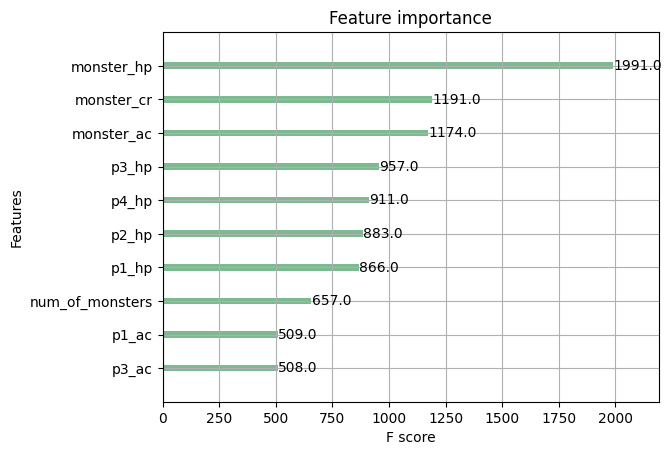

In [80]:
plot_importance(xgb_optuna, max_num_features=10)

## Training a model with the best hyperparameters on normalized data

In [86]:
from sklearn.preprocessing import MinMaxScaler


normalizer_class = MinMaxScaler()
X_encoded_normalized = normalizer_class.fit_transform(X_encoded)
X_encoded_normalized = pd.DataFrame(X_encoded_normalized, columns=X_encoded.columns)


In [87]:
df_test_encoded_normalized = normalizer_class.transform(df_test_encoded)
df_test_encoded_normalized = pd.DataFrame(df_test_encoded_normalized, columns=df_test_encoded.columns)

In [88]:
X_train_normalized, X_test_normalized, Y_train_normalized, Y_test_normalized = train_test_split(X_encoded_normalized, Y, test_size=0.2, random_state=7)

In [92]:
skf = StratifiedKFold(10, shuffle=True, random_state=7)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=7, n_jobs=-1)

    return cross_val_score(cls, X_train_normalized, Y_train_normalized,
                           cv=skf, scoring='accuracy').mean()

In [94]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', study_name='classification')
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)
studyXGB.best_params

[I 2023-12-09 18:17:11,567] A new study created in memory with name: classification
[I 2023-12-09 18:17:52,632] Trial 10 finished with value: 0.8497561885843463 and parameters: {'n_estimators': 88, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'min_child_weight': 7, 'colsample_bytree': 0.6000000000000001}. Best is trial 10 with value: 0.8497561885843463.
[I 2023-12-09 18:17:53,415] Trial 7 finished with value: 0.8576829919515333 and parameters: {'n_estimators': 71, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.2, 'min_child_weight': 1, 'colsample_bytree': 0.6000000000000001}. Best is trial 7 with value: 0.8576829919515333.
[I 2023-12-09 18:17:53,972] Trial 11 finished with value: 0.8628742655247613 and parameters: {'n_estimators': 52, 'max_depth': 6, 'learning_rate': 0.15000000000000002, 'gamma': 0.0, 'min_child_weight': 2, 'colsample_bytree': 0.3}. Best is trial 11 with value: 0.8628742655247613.
[I 2023-12-09 18:17:55,172] Trial 9 finished with value: 0.837440522562828 and p

{'n_estimators': 186,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.7}

In [95]:
params = {
    'n_estimators': 186,
    'max_depth': 7,
    'learning_rate': 0.2,
    'gamma': 0.2,
    'min_child_weight': 5,
    'colsample_bytree': 0.7
}

In [96]:
pesos = np.round(np.arange(0.5, 3, 0.01), 3)

params['random_state'] = 7

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train_normalized, Y_train_normalized)
    Y_pred = xgb_optuna.predict(X_test_normalized)

    tn, fp, fn, tp = confusion_matrix(Y_test_normalized, Y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.01:

        print(f'{i}\n')

2.1

2.14

2.16

2.17

2.18

2.19

2.2

2.21

2.22

2.23

2.24

2.25

2.26

2.27

2.28

2.29

2.3

2.31

2.32

2.33

2.34

2.35

2.36

2.37

2.38

2.39

2.4

2.41

2.42

2.43

2.44

2.45

2.46



0.9752251722898757
              precision    recall  f1-score   support

       False       0.96      0.91      0.93     13877
        True       0.83      0.92      0.87      6687

    accuracy                           0.91     20564
   macro avg       0.89      0.91      0.90     20564
weighted avg       0.91      0.91      0.91     20564



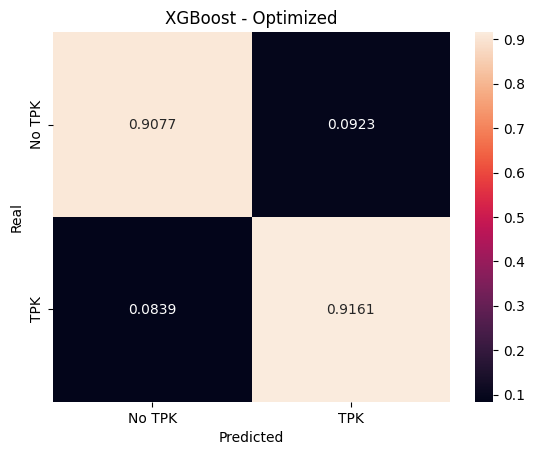

In [97]:
params['scale_pos_weight'] = 2.46

xgb_optuna_normalized = XGBClassifier()
xgb_optuna_normalized.set_params(**params)

xgb_optuna_normalized.fit(X_train_normalized, Y_train_normalized)

# Matriz de confusão do modelo XGBoost otimizado
ax = sns.heatmap(confusion_matrix(Y_test_normalized, xgb_optuna_normalized.predict(X_test_normalized), normalize='true'), annot=True, fmt='.4f', xticklabels=['No TPK', 'TPK'], yticklabels=['No TPK', 'TPK'])
ax.set_title('XGBoost - Optimized')
ax.set_xlabel('Predicted')
ax.set_ylabel('Real');
print(roc_auc_score(Y_test_normalized, xgb_optuna_normalized.predict_proba(X_test_normalized)[:,1]))
print(classification_report(Y_test_normalized, xgb_optuna_normalized.predict(X_test_normalized)))


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

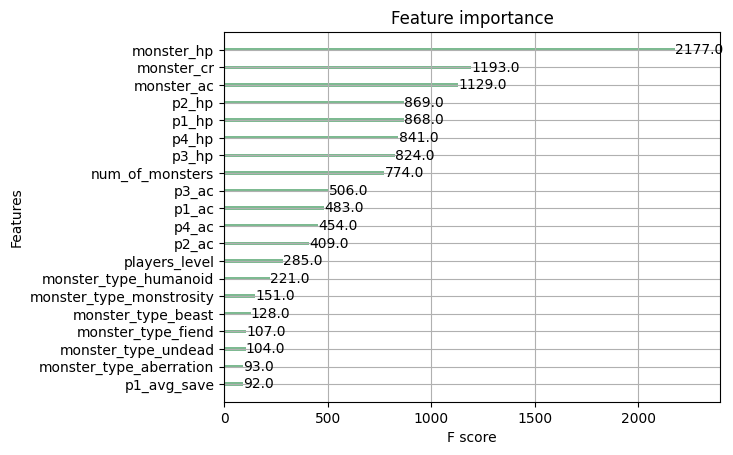

In [98]:
plot_importance(xgb_optuna_normalized, max_num_features=20)

In [99]:
xgb_optuna_normalized.save_model('model_opt_normalized_classification.ubj')

In [100]:
from random import randint

def predict(model,test, y,normalizer):
    input_test = randint(0, len(test))
    row_input = pd.DataFrame(test.iloc[input_test]).T
    try:
        print_input = pd.DataFrame(normalizer.inverse_transform(row_input), columns=row_input.columns)
    except:
        print('ruim')
        print_input = row_input 
    print('Input: ')
    display(row_input)
    print(f'The combat was between 4 players level {print_input.players_level.values[0]} against {print_input.num_of_monsters.values[0]} monster(s) CR {print_input.monster_cr.values[0]}')
    print('Expected: ', y.iloc[input_test])
    print(type(row_input.values))
    print('Predicted: ', bool(model.predict(row_input.values)[0]))

In [117]:
predict(xgb_optuna_normalized, df_test_encoded_normalized, df_test_result, normalizer=normalizer_class)

Input: 


,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_dragon,monster_type_elemental,monster_type_fey,monster_type_fiend,monster_type_giant,monster_type_humanoid,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead
4368,0.114286,0.4,0.0,0.217391,0.4,0.0,0.239437,0.9,0.0,0.173913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The combat was between 4 players level 2.0 against 10.0 monster(s) CR 0.0
Expected:  True
<class 'numpy.ndarray'>
Predicted:  True


In [134]:
from xgboost import XGBRegressor


model_loaded_class = XGBClassifier()
model_loaded_class.load_model('model_opt_normalized_classification.ubj')
model_loaded_reg = XGBRegressor()
model_loaded_reg.load_model('model_OPT_NORMALIZED.ubj')
new_data = pd.read_csv('../Data/test_sample.csv', encoding='utf-8')
new_data = new_data.iloc[randint(0,4000)].T.to_frame().T


classification_features_df = encoder_class.transform(new_data[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']]) # type: ignore
classification_data_encoded = pd.concat([new_data, classification_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type', 'monster_name','dificulty'])
classification_data_encoded_normalized = normalizer_class.transform(classification_data_encoded)


print(model_loaded_class.predict(classification_data_encoded_normalized))
print(model_loaded_reg.predict(classification_data_encoded_normalized))
print(new_data.dificulty.values[0])


[0]
[0.65144783]
0.7002070393374742
